<p><a href="https://colab.research.google.com/github/compgeog/choropleth-tradeoffs/blob/main/explore_choropleth_results.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></p>

# Spatial data generation for choropleth maps


This notebook is used to generate and save spatial data for choropleth maps of the United States.

The following cell makes sure the necessary libraries and modules are imported to run the experiments in the rest of this notebook.

In [1]:
from geom.shapex import *
from spatialanalysis.moransi2 import *
from cgl.cgl.util.get_adjacency_matrix import *
from cgl.cgl.util.draw_polygons_shapex import *
from cgl.cgl.util.get_attribute_by_name import *
from cgl.cgl.util.evaluate_all import *
from cgl.cgl.util.pareto_ranking import *
from cgl.cgl.util.parallel_coordinates import *
from cgl.cgl.util.xcolorbrewer import *
from cgl.cgl.util.breakpoints2 import *

import time
import random
# random.seed(10)
import numpy as np
import pickle
import math

import urllib.request as request

import json

import matplotlib.pyplot as plt
%matplotlib inline


# Map Data

In this tutorial, we use the base map of the counties in the conterminous United States. This data set has been used in many cartographic studies. The data is converted to a GeoJSON file and can be loaded directly from its [github source](https://raw.githubusercontent.com/compgeog/choropleth-tradeoffs/main/data/il/il.geojson).

In [3]:
baseMapPath = r'C:\Users\jiali\Desktop\CompSpatialPatternRecognition\code\mapGeneration\baseMaps'
f = open(baseMapPath + '\\' + 'uscnty48area_102008.geojson')
shp = json.load(f)

all_features = shp['features']
print(len(all_features))
baseMap = 'us'

3109


In [4]:
all_features[0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [5]:
all_features[0]['properties'].keys()

dict_keys(['NAME', 'STATE_NAME', 'FIPS', 'UrbanPop', 'Area', 'AreaKM2', 'GEO_ID', 'PopDensity'])

We need to get the bounds of the coordinates for each enumeration unit:

In [6]:
envelopes = get_feature_envelopes(all_features) # list of [xmin, ymin, xmax, ymax]
# geom_bounds = [min([p[0] for p in envelopes]), min([p[1] for p in envelopes]), max([p[2] for p in envelopes]), max([p[3] for p in envelopes])]
geom_bounds = {
    'xmin': min([p[0] for p in envelopes]), 
    'ymin': min([p[1] for p in envelopes]), 
    'xmax': max([p[2] for p in envelopes]), 
    'ymax': max([p[3] for p in envelopes])
}

geom_bounds # [xmin, ymin, xmax, ymax]

{'xmin': -2235809.497613872,
 'ymin': -1643544.949341902,
 'xmax': 2125197.68616152,
 'ymax': 1322159.8643133966}

Let's quickly draw a map to make sure the geometries are loaded correctly.

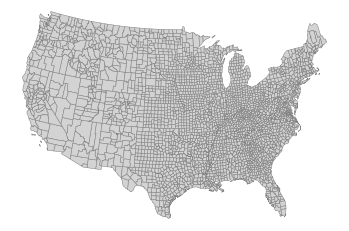

In [7]:
draw_shape(all_features)
plt.axis('off')
plt.axis('equal')
plt.show()

With the data loaded, we need to obtain the adjacency matrix (list), all the values of the attribute synthesized by us, and all the unique values (sorted). 

In [8]:
# adjacent list for the enumration units
adjacency_list = adjacency_matrix(all_features, output='L')
adjacency_list

[[3, 2],
 [5, 2],
 [5, 4],
 [6, 2],
 [6, 4],
 [6, 5],
 [7, 3],
 [8, 3],
 [9, 3],
 [9, 7],
 [10, 3],
 [10, 8],
 [10, 9],
 [11, 9],
 [11, 10],
 [12, 11],
 [13, 12],
 [14, 12],
 [14, 13],
 [15, 14],
 [16, 14],
 [16, 15],
 [17, 16],
 [21, 4],
 [21, 5],
 [23, 22],
 [25, 19],
 [25, 23],
 [25, 24],
 [26, 19],
 [26, 23],
 [26, 25],
 [27, 26],
 [28, 20],
 [28, 27],
 [29, 21],
 [30, 20],
 [30, 21],
 [30, 28],
 [30, 29],
 [31, 21],
 [31, 29],
 [31, 30],
 [32, 4],
 [32, 21],
 [32, 31],
 [34, 33],
 [35, 33],
 [36, 34],
 [38, 37],
 [40, 39],
 [41, 40],
 [42, 36],
 [42, 37],
 [43, 42],
 [44, 43],
 [45, 19],
 [45, 20],
 [45, 26],
 [45, 27],
 [45, 28],
 [46, 44],
 [47, 0],
 [50, 31],
 [50, 32],
 [50, 48],
 [51, 35],
 [53, 43],
 [53, 44],
 [53, 52],
 [54, 45],
 [54, 51],
 [55, 51],
 [55, 52],
 [57, 56],
 [58, 56],
 [59, 30],
 [59, 31],
 [59, 50],
 [60, 51],
 [60, 54],
 [60, 55],
 [60, 56],
 [60, 57],
 [61, 20],
 [61, 45],
 [61, 54],
 [61, 59],
 [62, 20],
 [62, 30],
 [62, 59],
 [62, 61],
 [63, 48],
 [63,

Specify the parameters to synthesize maps besides base map, including color scheme, number of classes

In [9]:
numclass = 4
colorScheme = 'Blues'
# colorScheme = 'RdBu'

#### 1. Generate spatial data (all values) with negative spatial autocorrelation for the enumeration units

##### (1) Use checker board with full negative spatial autocorrelation to overlap with the base map (doesn't work to synthesize data with significant negative spatial autocorrelation)

In [10]:
# power = 6
# size = 2**power + 1
# size = 8
# negAutoCorMatrix = np.zeros(shape=(size, size))
# size

In [11]:
# for i in range(size):
#     for j in range(size):
#         if (i + j) % 2 == 0:
#             x = random.uniform(0.5, 1)
#         else:
#             x = random.uniform(0, 0.5)
#         negAutoCorMatrix[i][j] = x
# H_scaled = negAutoCorMatrix
# plt.imshow(H_scaled, interpolation='none')
# plt.colorbar(orientation='vertical')
# plt.show()

##### (2) Use BFS to synthesize data for units and adjacent units to make sure they are not in the same class  

In [12]:
# find units adjacent to target unit
def getAdjacentUnits(adjacency_list, targetID):
    adjUnitList = []
    for pair in adjacency_list:
        if pair[0] == targetID:
            adjUnitList.append(pair[1])
        elif pair[1] == targetID:
            adjUnitList.append(pair[0])
    return adjUnitList

Initialize all_values with the same size of all_features, and assign small value to the first value in all_values

In [13]:
all_values = [-1 for i in range(len(all_features))] # initialize all_values with the same size of all_features
all_values[0] = random.uniform(0.5, 1)
visitedIDs = set()
visitedIDs.add(0)
currentQueue = []
currentQueue.append(0)

Generate data with negative spatial autocorrelation

In [14]:
while len(currentQueue) != 0:
    i =  currentQueue.pop(0)
    name =  all_features[i]['properties']['NAME']
    geoID =  all_features[i]['properties']['GEO_ID']
    print('name: %s geoID: %s' %(name, geoID))
    adjUnitList = getAdjacentUnits(adjacency_list,i)
    for adjUnit in adjUnitList:
        if adjUnit not in visitedIDs:
            if all_values[i] > 0.5:
                all_values[adjUnit] = random.uniform(0, 0.5)
            else:
                all_values[adjUnit] = random.uniform(0.5, 1)
            visitedIDs.add(adjUnit)
            currentQueue.append(adjUnit)
for i in range(len(all_values)):
    if all_values[i] == -1:
        all_values[i] = random.uniform(0, 1)
all_values_neg = all_values

name: Gallatin geoID: 05000US30031
name: Madison geoID: 05000US30057
name: Meagher geoID: 05000US30059
name: Jefferson geoID: 05000US30043
name: Park geoID: 05000US30067
name: Broadwater geoID: 05000US30007
name: Teton geoID: 05000US56039
name: Park geoID: 05000US56029
name: Fremont geoID: 05000US16043
name: Silver Bow geoID: 05000US30093
name: Beaverhead geoID: 05000US30001
name: Lewis and Clark geoID: 05000US30049
name: Judith Basin geoID: 05000US30045
name: Cascade geoID: 05000US30013
name: Wheatland geoID: 05000US30107
name: Sweet Grass geoID: 05000US30097
name: Powell geoID: 05000US30077
name: Deer Lodge geoID: 05000US30023
name: Carbon geoID: 05000US30009
name: Stillwater geoID: 05000US30095
name: Fremont geoID: 05000US56013
name: Lincoln geoID: 05000US56023
name: Bonneville geoID: 05000US16019
name: Teton geoID: 05000US16081
name: Sublette geoID: 05000US56035
name: Hot Springs geoID: 05000US56017
name: Big Horn geoID: 05000US56003
name: Washakie geoID: 05000US56043
name: Clark g

name: Piute geoID: 05000US49031
name: Garfield geoID: 05000US49017
name: Navajo geoID: 05000US04017
name: Coconino geoID: 05000US04005
name: Apache geoID: 05000US04001
name: Kane geoID: 05000US49025
name: San Miguel geoID: 05000US08113
name: Dolores geoID: 05000US08033
name: Montezuma geoID: 05000US08083
name: San Juan geoID: 05000US35045
name: Beaver geoID: 05000US49001
name: Ouray geoID: 05000US08091
name: Washington geoID: 05000US08121
name: Yuma geoID: 05000US08125
name: Sedgwick geoID: 05000US08115
name: Phillips geoID: 05000US08095
name: Denver geoID: 05000US08031
name: Arapahoe geoID: 05000US08005
name: Douglas geoID: 05000US08035
name: Teller geoID: 05000US08119
name: Garden geoID: 05000US31069
name: Sheridan geoID: 05000US31161
name: Deuel geoID: 05000US31049
name: Fremont geoID: 05000US08043
name: Saguache geoID: 05000US08109
name: Hinsdale geoID: 05000US08053
name: Dewey geoID: 05000US46041
name: Stanley geoID: 05000US46117
name: Bennett geoID: 05000US46007
name: Cherry geoI

name: Grant geoID: 05000US46051
name: Codington geoID: 05000US46029
name: Kingsbury geoID: 05000US46077
name: Miner geoID: 05000US46097
name: Hamlin geoID: 05000US46057
name: Roosevelt geoID: 05000US35041
name: Lea geoID: 05000US35025
name: Presidio geoID: 05000US48377
name: Jeff Davis geoID: 05000US48243
name: Reeves geoID: 05000US48389
name: Loving geoID: 05000US48301
name: Curry geoID: 05000US35009
name: Deaf Smith geoID: 05000US48117
name: Oldham geoID: 05000US48359
name: Graham geoID: 05000US20065
name: Trego geoID: 05000US20195
name: Lane geoID: 05000US20101
name: Ness geoID: 05000US20135
name: Finney geoID: 05000US20055
name: Grant geoID: 05000US20067
name: Haskell geoID: 05000US20081
name: Stevens geoID: 05000US20189
name: Harlan geoID: 05000US31083
name: Phillips geoID: 05000US20147
name: Franklin geoID: 05000US31061
name: Texas geoID: 05000US40139
name: Sherman geoID: 05000US48421
name: Moore geoID: 05000US48341
name: Potter geoID: 05000US48375
name: Dixon geoID: 05000US31051

name: Stephens geoID: 05000US40137
name: Garvin geoID: 05000US40049
name: Pontotoc geoID: 05000US40123
name: Cotton geoID: 05000US40033
name: Wichita geoID: 05000US48485
name: Archer geoID: 05000US48009
name: Young geoID: 05000US48503
name: Stephens geoID: 05000US48429
name: Polk geoID: 05000US19153
name: Warren geoID: 05000US19181
name: Clarke geoID: 05000US19039
name: Story geoID: 05000US19169
name: Ringgold geoID: 05000US19159
name: Decatur geoID: 05000US19053
name: Franklin geoID: 05000US19069
name: Hardin geoID: 05000US19083
name: Cerro Gordo geoID: 05000US19033
name: Worth geoID: 05000US19195
name: Mower geoID: 05000US27099
name: Buchanan geoID: 05000US29021
name: Platte geoID: 05000US29165
name: Leavenworth geoID: 05000US20103
name: Johnson geoID: 05000US20091
name: Miami geoID: 05000US20121
name: Linn geoID: 05000US20107
name: Anderson geoID: 05000US20003
name: Allen geoID: 05000US20001
name: DeKalb geoID: 05000US29063
name: Daviess geoID: 05000US29061
name: Harrison geoID: 050

name: Angelina geoID: 05000US48005
name: Smith geoID: 05000US48423
name: Douglas geoID: 05000US29067
name: Taney geoID: 05000US29213
name: Boone geoID: 05000US05009
name: Newton geoID: 05000US05101
name: Johnson geoID: 05000US05071
name: Yell geoID: 05000US05149
name: Pope geoID: 05000US05115
name: Montgomery geoID: 05000US05097
name: Howard geoID: 05000US05061
name: Pike geoID: 05000US05109
name: Hempstead geoID: 05000US05057
name: Miller geoID: 05000US05091
name: Cass geoID: 05000US48067
name: Upshur geoID: 05000US48459
name: Marion geoID: 05000US48315
name: Clinton geoID: 05000US19045
name: Scott geoID: 05000US19163
name: Des Moines geoID: 05000US19057
name: Henderson geoID: 05000US17071
name: Rock Island geoID: 05000US17161
name: Mercer geoID: 05000US17131
name: Hancock geoID: 05000US17067
name: Adams geoID: 05000US17001
name: Pike geoID: 05000US17149
name: Green geoID: 05000US55045
name: Stephenson geoID: 05000US17177
name: Carroll geoID: 05000US17015
name: Rock geoID: 05000US5510

name: Bolivar geoID: 05000US28011
name: Coahoma geoID: 05000US28027
name: Tunica geoID: 05000US28143
name: Issaquena geoID: 05000US28055
name: East Carroll geoID: 05000US22035
name: Washington geoID: 05000US28151
name: Madison geoID: 05000US22065
name: Tensas geoID: 05000US22107
name: Iroquois geoID: 05000US17075
name: Vermilion geoID: 05000US17183
name: Edgar geoID: 05000US17045
name: Clark geoID: 05000US17023
name: Jasper geoID: 05000US17079
name: Richland geoID: 05000US17159
name: Pulaski geoID: 05000US18131
name: White geoID: 05000US18181
name: Benton geoID: 05000US18007
name: Starke geoID: 05000US18149
name: LaPorte geoID: 05000US18091
name: Williamson geoID: 05000US17199
name: Franklin geoID: 05000US17055
name: Alexander geoID: 05000US17003
name: Johnson geoID: 05000US17087
name: Pulaski geoID: 05000US17153
name: Mississippi geoID: 05000US29133
name: Fulton geoID: 05000US21075
name: Lake geoID: 05000US47095
name: Dyer geoID: 05000US47045
name: Shelby geoID: 05000US47157
name: Lau

name: Franklin geoID: 05000US39049
name: Morrow geoID: 05000US39117
name: Clinton geoID: 05000US39027
name: Fayette geoID: 05000US39047
name: St. Clair geoID: 05000US26147
name: Sanilac geoID: 05000US26151
name: Huron geoID: 05000US26063
name: Leelanau geoID: 05000US26089
name: Antrim geoID: 05000US26009
name: Otsego geoID: 05000US26137
name: Oscoda geoID: 05000US26135
name: Montmorency geoID: 05000US26119
name: Alcona geoID: 05000US26001
name: Iosco geoID: 05000US26069
name: Smith geoID: 05000US47159
name: DeKalb geoID: 05000US47041
name: Clay geoID: 05000US47027
name: Jackson geoID: 05000US47087
name: Grundy geoID: 05000US47061
name: Warren geoID: 05000US47177
name: Marion geoID: 05000US47115
name: DeKalb geoID: 05000US01049
name: Dade geoID: 05000US13083
name: Cherokee geoID: 05000US01019
name: Russell geoID: 05000US21207
name: Clinton geoID: 05000US21053
name: Bullock geoID: 05000US01011
name: Macon geoID: 05000US01087
name: Pike geoID: 05000US01109
name: Coffee geoID: 05000US01031

name: Putnam geoID: 05000US12107
name: Lake geoID: 05000US12069
name: Volusia geoID: 05000US12127
name: Sumter geoID: 05000US12119
name: Hernando geoID: 05000US12053
name: Brantley geoID: 05000US13025
name: Pierce geoID: 05000US13229
name: Edgefield geoID: 05000US45037
name: Columbia geoID: 05000US13073
name: Richmond geoID: 05000US13245
name: Caldwell geoID: 05000US37027
name: Wilkes geoID: 05000US37193
name: Floyd geoID: 05000US51063
name: Patrick geoID: 05000US51141
name: Yadkin geoID: 05000US37197
name: Forsyth geoID: 05000US37067
name: Stokes geoID: 05000US37169
name: Huntingdon geoID: 05000US42061
name: Fulton geoID: 05000US42057
name: Washington geoID: 05000US24043
name: Morgan geoID: 05000US54065
name: Union geoID: 05000US42119
name: Columbia geoID: 05000US42037
name: Northumberland geoID: 05000US42097
name: Montour geoID: 05000US42093
name: Bradford geoID: 05000US42015
name: Sullivan geoID: 05000US42113
name: Chemung geoID: 05000US36015
name: Ontario geoID: 05000US36069
name: 

name: Beaufort geoID: 05000US45013
name: Lee geoID: 05000US12071
name: Collier geoID: 05000US12021
name: Broward geoID: 05000US12011
name: Durham geoID: 05000US37063
name: Harnett geoID: 05000US37085
name: Lee geoID: 05000US37105
name: Wake geoID: 05000US37183
name: Hoke geoID: 05000US37093
name: Scotland geoID: 05000US37165
name: Cumberland geoID: 05000US37051
name: Baltimore City geoID: 05000US24510
name: Calvert geoID: 05000US24009
name: King George geoID: 05000US51099
name: St. Mary's geoID: 05000US24037
name: Passaic geoID: 05000US34031
name: Orange geoID: 05000US36071
name: Morris geoID: 05000US34027
name: Hunterdon geoID: 05000US34019
name: Mercer geoID: 05000US34021
name: Burlington geoID: 05000US34005
name: Philadelphia geoID: 05000US42101
name: Delaware geoID: 05000US42045
name: New Castle geoID: 05000US10003
name: Kent geoID: 05000US24029
name: Ulster geoID: 05000US36111
name: Otsego geoID: 05000US36077
name: Schoharie geoID: 05000US36095
name: Greene geoID: 05000US36039
nam

In [15]:
unique_values = list(set(all_values_neg))
m = len(all_values_neg)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 9.931387322331675e-05 0.9996232341691897


We can also show a histogram of the data.

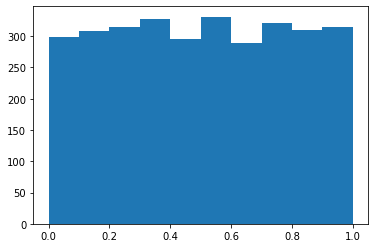

In [16]:
plt.hist(all_values_neg)
plt.show()

##### Defining a classification

A Python class called `Intervals` is defined in the [classify.py](https://github.com/compgeog/cgl/blob/master/cgl/util/classify.py) that will be cloned here (see the beginning of this tutorial). There are multiple ways to create a classification. Below is an example using a set of lower and upper bounds:

In [17]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

We can draw a choropleth map using the classification scheme created from the above section. 

We first need to calculate the geometry bounds of the map, which will be used later.

In [18]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

We draw the map using the intervals stored in `intervals`:

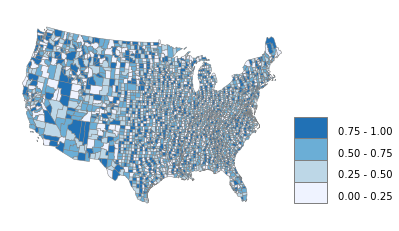

In [19]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_neg]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/8  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()


Calculate gobal Moran's I for the data with the base map

In [20]:
classes = [intervals.get_class(v) for v in all_values_neg]

In [21]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_neg[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_neg, adjacency_list)

-0.2028744787316258

In [22]:
dataGenerationPath = r'C:\Users\jiali\Desktop\choroplethClassAnalysis\mapGeneration\code'

In [ ]:
with open(dataGenerationPath + '\\' + baseMap + '_' + 'all_values_neg.pickle', 'wb') as f:
    pickle.dump(all_values_neg,f)

#### 2. Generate spatial data (all values) with NO spatial autocorrelation for the enumeration units

In [24]:
# randomly select values for nonpattern maps
all_values_nonAuto = [random.uniform(0, 1) for i in range(len(all_features))] 

In [25]:
unique_values = list(set(all_values_nonAuto))
m = len(all_values_nonAuto)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3109 3109 0.0005691767531534886 0.9999011072527904


In [26]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [27]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

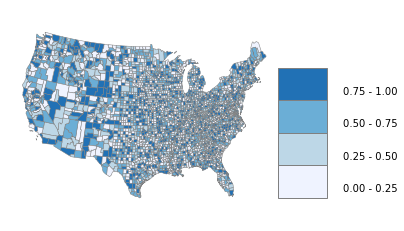

In [28]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_nonAuto]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [29]:
classes = [intervals.get_class(v) for v in all_values_nonAuto]

In [30]:
class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
class_means = [ sum([all_values_nonAuto[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
                for j in range(numclass) ]
means = [ class_means[i] for i in classes ]
moransi2(all_values_nonAuto, adjacency_list)

-0.012715565610974125

In [ ]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_nonAuto.pickle', 'wb') as f:
    pickle.dump(all_values_nonAuto,f)

#### 3. Generate spatial data (all values) with POSITIVE spatial autocorrelation for the enumeration units

We use midpoint displacement interpolation to generate a grid with some trend to synthesize data with positive spatial autocorrelation.

The next a couple of cells are the functions needed for this section

In [32]:
def f(delta, x):
    return sum(x)/len(x)+delta*random.gauss(0,1)

def midpoint2d(maxlevel, sigma, H, addition=False):
    N = int(math.pow(2, maxlevel))
    X = [ [0]*(N+1) for x in range(N+1)]
    delta = sigma
    X[0][0] = delta*random.gauss(0,1)
    X[0][N] = delta*random.gauss(0,1)
    X[N][0] = delta*random.gauss(0,1)
    X[N][N] = delta*random.gauss(0,1)
    D = N
    d = int(N/2)
    for stage in range(1, maxlevel+1):
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x+d][y+d], X[x+d][y-d],
                                    X[x-d][y+d], X[x-d][y-d]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        delta = delta*math.pow(0.5, 0.5*H)
        for x in range(d, N-d+1, D):
            X[x][0] = f(delta,[X[x+d][0],X[x-d][0],X[x][d]])
            X[x][N] = f(delta,[X[x+d][N],X[x-d][N],X[x][N-d]])
            X[0][x] = f(delta,[X[0][x+d],X[0][x-d],X[d][x]])
            X[N][x] = f(delta,[X[N][x+d],X[N][x-d],X[N-d][x]])
        for x in range(d, N-d+1, D):
            for y in range(D, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x][y-d],
                                    X[x+d][y], X[x+d][y]])
        for x in range(D, N-d+1, D):
            for y in range(d, N-d+1, D):
                X[x][y] = f(delta, [X[x][y+d], X[x+d][y-d],
                                    X[x+d][y], X[x-d][y]])
        if addition is True:
            for x in range(0, N+1, D):
                for y in range(0, N+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
            for x in range(d, N-d+1, D):
                for y in range(d, N-d+1, D):
                    X[x][y] += delta*random.gauss(0, 1)
        D = int(D/2)
        d = int(d/2)
    return X

In [33]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [34]:
def getValueUnit(envelopes, generatedMatrix, geom_bounds):
    # get generated data for each enumeration unit in the map
    # envelopes are for each unit, generatedMatrix is the generated matrix
    # return a list of value for each unit
    valueListUnit = []
    boundXMin = geom_bounds['xmin']
    boundXMax = geom_bounds['xmax']
    boundXRange = boundXMax - boundXMin
    boundYMin = geom_bounds['ymin']
    boundYMax = geom_bounds['ymax']
    boundYRange = boundYMax - boundYMin
       
    for envelope in envelopes:
        xMid = (envelope[0] + envelope[2])/2
        yMid = (envelope[1] + envelope[3])/2
        
        xIndex = int((xMid - boundXMin) / boundXRange * generatedMatrix.shape[0]) - 1 
        if xIndex < 0:
            xIndex = 0
        yIndex = int((yMid - boundYMin) / boundYRange * generatedMatrix.shape[0]) - 1 
        if yIndex < 0:
            yIndex = 0
        value = generatedMatrix[yIndex][xIndex]
        valueListUnit.append(value)
    return valueListUnit

##### (1) large positive spatial autocorrelation

Conduct midpoint displacement interpolation

In [35]:
maxlevel = 8
sigma = 0.5
H = 0.5
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [36]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

Visualize generated matrix with some trend

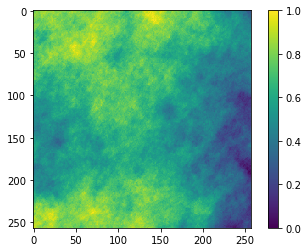

In [37]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [38]:
# get value from generated data with MidPoint2.py
all_values_pos_large = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [39]:
all_values_pos_large.sort()

In [40]:
all_values_pos_large.sort(reverse=True)
all_values_pos_large

[0.9408948480739991,
 0.9389606341237932,
 0.9374674153807426,
 0.930363591044078,
 0.9269114584639064,
 0.9252844117246156,
 0.8981416757609749,
 0.8929175374276513,
 0.8910931398061559,
 0.8908596771035266,
 0.8860056372232828,
 0.8742604441830051,
 0.8696223016803383,
 0.8624231286942349,
 0.8618310617248365,
 0.8522914970113469,
 0.8514937766119512,
 0.8425178004362959,
 0.8423056281622863,
 0.8420590880636265,
 0.8395176672363781,
 0.8395152503315761,
 0.837627932312064,
 0.8361832823340012,
 0.8334970092440319,
 0.8263691726835138,
 0.8261506275958393,
 0.8225291088919924,
 0.8212450011100771,
 0.8209362183123916,
 0.8201554752594267,
 0.8193910679381795,
 0.8179047924700872,
 0.8174493819753871,
 0.8173268945184815,
 0.81721522472156,
 0.8163809750976523,
 0.8152412777776544,
 0.81492815714986,
 0.8148627706724892,
 0.8144660096966365,
 0.8140285357149807,
 0.8119090335847937,
 0.811080477617605,
 0.8102351575536302,
 0.8076507549576091,
 0.8075570625300953,
 0.8074664582580166,

In [41]:
gaps = [ (all_values_pos_large[i] - all_values_pos_large[i+1]) for i in range(len(all_values_pos_large)-1)]
gaps

[0.0019342139502059874,
 0.0014932187430505284,
 0.007103824336664677,
 0.0034521325801715186,
 0.0016270467392908161,
 0.027142735963640696,
 0.00522413833332358,
 0.0018243976214954438,
 0.00023346270262925017,
 0.004854039880243799,
 0.011745193040277768,
 0.004638142502666809,
 0.007199172986103397,
 0.0005920669693983971,
 0.009539564713489601,
 0.0007977203993956294,
 0.008975976175655376,
 0.00021217227400960326,
 0.00024654009865976434,
 0.0025414208272483974,
 2.416904801960662e-06,
 0.0018873180195121408,
 0.0014446499780628175,
 0.002686273089969271,
 0.007127836560518075,
 0.0002185450876744932,
 0.003621518703846971,
 0.0012841077819152336,
 0.0003087827976855362,
 0.0007807430529649384,
 0.0007644073212471625,
 0.001486275468092324,
 0.00045541049470010364,
 0.0001224874569055734,
 0.00011166979692145418,
 0.0008342496239077679,
 0.0011396973199978566,
 0.0003131206277944276,
 6.538647737075465e-05,
 0.00039676097585272796,
 0.00043747398165583373,
 0.0021195021301869676,

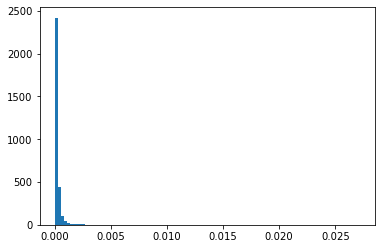

In [42]:
plt.hist(gaps, bins = 100)
plt.show()

In [43]:
unique_values = list(set(all_values_pos_large))
m = len(all_values_pos_large)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))

3093 3109 0.06727986112064739 0.9408948480739991


In [44]:
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [45]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

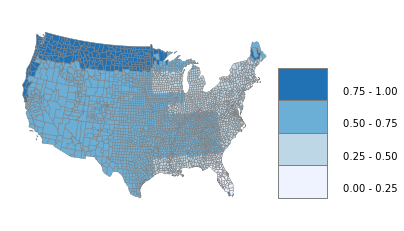

In [46]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_large]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [47]:
classes = [intervals.get_class(v) for v in all_values_pos_large]

In [48]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values_pos_large[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_large, adjacency_list)

0.8936613706955004

In [ ]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_large.pickle', 'wb') as f:
    pickle.dump(all_values_pos_large,f)

##### (2) small positive spatial autocorrelation

In [46]:
maxlevel = 12
sigma = 0.1
H = 0.1
if len(sys.argv) == 4:
    maxlevel = string.atoi(sys.argv[1])
    sigma = string.atof(sys.argv[2])
    H = string.atof(sys.argv[3])
X = midpoint2d(maxlevel, sigma, H)

In [47]:
generatedMatrix = np.array(X)
generatedMatrixNorm = NormalizeData(generatedMatrix)

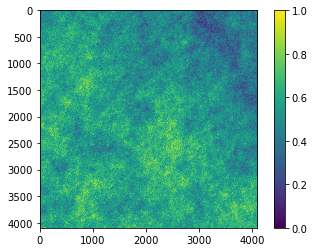

In [48]:
plt.imshow(generatedMatrixNorm, interpolation='none')
plt.colorbar(orientation='vertical')
plt.show()

In [49]:
# get value from generated data with MidPoint2.py
all_values_pos_small = getValueUnit(envelopes, generatedMatrixNorm, geom_bounds)
# all_values

In [ ]:
plt.hist(all_values_pos_small)
plt.show()

In [27]:
unique_values = list(set(all_values_pos_small))
m = len(all_values_pos_small)     # number of all values in data
n = len(unique_values)  # number of unique values in data
print(n, m, min(unique_values), max(unique_values))
intervals = Intervals()
intervals_bounds = [ [0, 0.25], [0.25, 0.5], [0.5, 0.75], [0.75, 1] ]
intervals.set_classes(intervals_bounds)
intervals

3109 3109 0.22672875657271283 0.851694407224588


[0 - 0.25], [0.25 - 0.5], [0.5 - 0.75], [0.75 - 1]

In [28]:
xmin, ymin, xmax, ymax = geom_bounds['xmin'], geom_bounds['ymin'], geom_bounds['xmax'], geom_bounds['ymax']

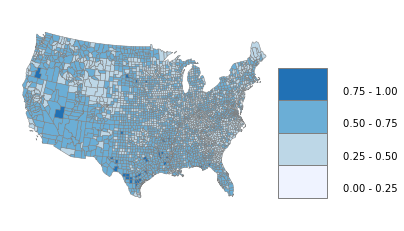

In [29]:
# get the classes using the break points in intervals
classes = [intervals.get_class(v) for v in all_values_pos_small]

# get the color scheme
colors = get_colorbrewer_specs(colorScheme, numclass)

# set up the canvas (ax0 is used in rect_legend)
_, ax0 = plt.subplots()

draw_shape(all_features, classes, colors)

box_w = (geom_bounds['xmax']-geom_bounds['xmin'])/5  # a fraction of the total with
box_h = box_w*2/3      # slightly smaller than the width
label_xgap = box_w / 3
label_ygap = box_h * 0.2

rect_legend(xmax*1.1, ymin, box_w, box_h, label_xgap, ax0, colors, ygap=label_ygap, edgecolor='grey', intervals=intervals, num_digits=2)

plt.axis('off')
plt.axis('equal')
plt.show()

In [30]:
classes = [intervals.get_class(v) for v in all_values_pos_small]

In [31]:
# class_counts = [ len([i for i in classes if i==j]) for j in range(numclass) ] 
# class_means = [ sum([all_values[i] for i in range(m) if classes[i]==j])/float(class_counts[j])
#                 for j in range(numclass) ]
# means = [ class_means[i] for i in classes ]
moransi2(all_values_pos_small, adjacency_list)

0.45103197520594795

In [32]:
with open(dataGenerationPath + '\\'+ baseMap + '_' +'all_values_pos_small.pickle', 'wb') as f:
    pickle.dump(all_values_pos_small,f)